<h1>Reinforcement Learning Final Project - Stock Trading Algorithm</h1>
    
<br>
Implementation using the 
"anytrading" environment in OpenAIGym
<br>
https://github.com/AminHP/gym-anytrading

In [3]:
pip install gym-anytrading

Note: you may need to restart the kernel to use updated packages.


In [4]:
# importing the OpenAIGym Environment for stock trading
import gym
import gym_anytrading
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from gym_anytrading.datasets import STOCKS_GOOGL
import random


In [5]:
# Google Stock dataset
STOCKS_GOOGL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100
...,...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000


In [113]:
env = gym.make('stocks-v0')
env_1 = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 1,
               frame_bound = (1000, 1500))

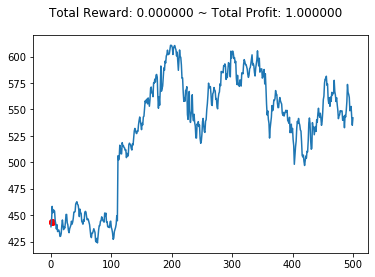

In [114]:
env_1.reset()
env_1.render()

Max_possible_profit signifies that if the market didn't have trade fees, you could have earned 12.468122338293616 units of currency by starting with 1.0. In other words, your money increased over 1200%.

In [8]:
env_1.max_possible_profit()

12.468122338293616

In [9]:
print(env_1.action_space)
print(env_1.observation_space.low.size)
# 0 for sell and 1 for buying

Discrete(2)
20


In [10]:
action = 1
print(env_1.step(action))

(array([[410.625641,  -2.072052],
       [415.220215,   4.594574],
       [423.283295,   8.06308 ],
       [431.206207,   7.922912],
       [429.044037,  -2.16217 ],
       [437.252258,   8.208221],
       [436.176178,  -1.07608 ],
       [440.555542,   4.379364],
       [439.204193,  -1.351349],
       [443.993988,   4.789795]]), 0, False, {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1})


In [11]:
observation, reward, done, info = env_1.step(action)

<h2>Random and Heuristic Methods:</h2>

<h3>Method 1: Random Buy/Sell</h3>

[[412.697693   0.      ]
 [410.625641  -2.072052]
 [415.220215   4.594574]
 [423.283295   8.06308 ]
 [431.206207   7.922912]
 [429.044037  -2.16217 ]
 [437.252258   8.208221]
 [436.176178  -1.07608 ]
 [440.555542   4.379364]
 [439.204193  -1.351349]]
info:  {'total_reward': 105.06594700000034, 'total_profit': 0.19011258700896214, 'position': 1}


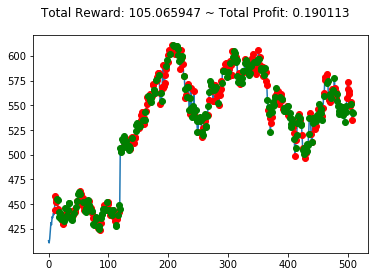

In [12]:
state = env_1.reset()
print(state)
while True:
    action = env_1.action_space.sample()
    state, reward, done, info = env_1.step(action)

    if done:
        print("info: ", info)
        break

env_1.render_all()

<h3>Method 2: Buy low sell high (last ten days moving average)</h3>

info:  {'total_reward': -50.05553899999899, 'total_profit': 0.4721159811550719, 'position': 0}


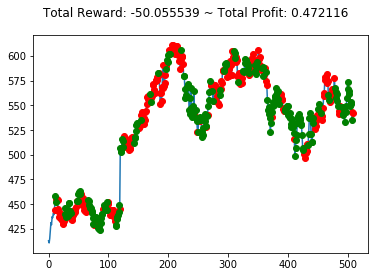

In [13]:
observation = env_1.reset()

last_ten_days = [] # moving average
moving_avg = 0
while True:
    if len(last_ten_days) < 10:
        last_ten_days.append(observation[0][0])
    else:
        last_ten_days.pop(0)
        last_ten_days.append(observation[0][0])
    moving_avg = sum(last_ten_days) / len(last_ten_days)
    
    
    if observation[0][0] < moving_avg:
        action = 1 # buy)
    elif observation[0][0] > moving_avg:
        action = 0 # sell
    
    observation, reward, done, info = env_1.step(action)

    if done:
        print("info: ", info)
        break

env_1.render_all()
    

<h3>Method 3: Buy and Hold Strategy</h3>
<br>
Buy the stock at the beginning and hold throughout the period and sell stock at the very end.

info:  {'total_reward': 94.43661499999996, 'total_profit': 1.1879821448544323, 'position': 0}


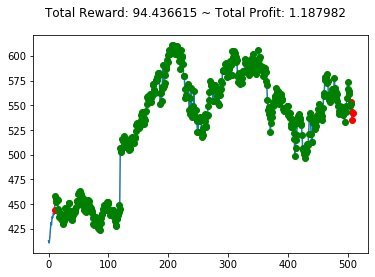

In [14]:
state = env_1.reset()
count = 0
while True:
    count += 1
    action = 1
    if count > 495:
        action = 0
    state, reward, done, info = env_1.step(action)
    
    if done:
        print("info: ", info)
        break

env_1.render_all()

<h2>Reinforcement Learning Methods:</h2>

<h3>Method 4: Deep Q-Learning (DQN)</h3>

In [159]:
# environment for training
env_training = gym.make('stocks-v0', df = STOCKS_GOOGL, window_size = 1, frame_bound = (1, 1000))

In [160]:
# Parameters
gamma = 0.99
actsize = env_training.action_space.n
obssize = int(env_training.observation_space.low.size/2) # divide by two to get rid of the price diff as obs

In [161]:
def model_creator():
    model = keras.Sequential()
    model.add(layers.Dense(32,activation="relu"))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(actsize,activation="linear"))
    return model

In [264]:
batch_size = 10
# Model used for selecting actions (principal)
model = model_creator()
# Then create the target model. This will periodically be copied from the principal network 
model_target = model_creator()

model.build((batch_size,obssize))
model_target.build((batch_size,obssize))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (10, 32)                  64        
_________________________________________________________________
dense_81 (Dense)             (10, 128)                 4224      
_________________________________________________________________
dense_82 (Dense)             (10, 128)                 16512     
_________________________________________________________________
dense_83 (Dense)             (10, 2)                   258       
Total params: 21,058
Trainable params: 21,058
Non-trainable params: 0
_________________________________________________________________


**Training the Model:**

In [265]:
tf.keras.backend.set_floatx('float64')

In [266]:
def vectorize_state(state):
    vector = []
    for i in range(len(state)):
        vector.append(state[i][0])
        vector.append(state[i][1])
    
    return vector

In [267]:
# training multiple epochs with the same dataset with epsilon decaying over epochs
def epoch_train(model, model_target, env_training, max_epochs, epsilon, adpative):
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)

    # Our Experience Replay memory 
    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    running_rewards_history = []

    # Replay memory size
    max_memory = 100 # You can experiment with different sizes.

    running_reward = 0
    frame_count = 0
    
    update_after_actions = 4

    # How often to update the target network
    target_update_every = 50
    loss_function = keras.losses.MeanSquaredError()

    for epoch in range(max_epochs): 
        state = env_training.reset()
        state = vectorize_state(state)[0]
        timestep_count = 0
        
        # adpative epsilon decay
        if adpative:
            epsilon = np.exp(-1e-0 * epoch)

        while True:
            timestep_count += 1
            frame_count += 1

            # exploration
            rand = np.random.uniform(0, 1)
            if rand < epsilon:
                # Take random action
                action = np.random.choice(actsize)
            else:
                # Predict action Q-values
                # From environment state
                state_t = tf.convert_to_tensor(state)
                state_t = tf.expand_dims(state_t, 0)
                action_vals = model(state_t, training=False)

                # Choose the best action
                action = int(tf.keras.backend.argmax(action_vals))

            state_next, reward, done, info = env_training.step(action)
            state_next = vectorize_state(state_next)[0]

            # Save action/states and other information in replay buffer
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            rewards_history.append(reward)
            done_history.append(done)
            running_rewards_history.append(info['total_reward'])

            running_reward = info['total_reward']

            state = state_next

            # Update every Xth frame to speed up (optional)
            # and if you have sufficient history
            if timestep_count % update_after_actions == 0 and len(action_history) > batch_size:
                # Sample a set of batch_size memories from the history
                rand_samples = np.random.randint(0, len(action_history), batch_size)

                action_sample = np.array(action_history)[rand_samples]
                state_sample = np.array(state_history)[rand_samples]
                state_next_sample = np.array(state_next_history)[rand_samples]
                rewards_sample = np.array(rewards_history)[rand_samples]
                done_sample = np.array(done_history)[rand_samples]

                # Create for the sample states the targets (r+gamma * max Q(...)
                state_next_sample_t = tf.convert_to_tensor(state_next_sample)
                Q_next_state = np.max(model_target.predict(state_next_sample_t), axis=1)   
                Q_targets = rewards_sample + gamma * Q_next_state

                # What actions are relevant and need updating
                relevant_actions = tf.cast(tf.one_hot(action_sample, actsize), tf.double)

                # we will use Gradient tape to do a custom gradient 
                # in the `with` environment we will record a set of operations
                # and then we will take gradients with respect to the trainable parameters
                # in the neural network
                with tf.GradientTape() as tape:
                    # Train the model on your action selecting network
                    q_values = model(state_sample) 
                    # We consider only the relevant actions
                    Q_of_actions = tf.reduce_sum(tf.multiply(q_values, relevant_actions), axis=1)
                    # Calculate loss between principal network and target network
                    loss = loss_function(Q_targets, Q_of_actions)

                    # Nudge the weights of the trainable variables towards 
                    grads = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if timestep_count % target_update_every == 0:
                # update the the target network with new weights
                model_target.set_weights(model.get_weights())
                # Log details
                #template = "running reward: {:.2f} at episode {}, total profit: {} epsilon {}"
                #print(template.format(running_reward, timestep_count, info["total_profit"], epsilon))

            # Don't let the memory grow beyond the limit
            if len(rewards_history) > max_memory:
                del action_history[:1]
                del state_history[:1]
                del state_next_history[:1]
                del rewards_history[:1]
                del done_history[:1]

            if done:
                #print("info: ", info)
                # Log details
                template = "running reward: {:.2f} at episode {}, frame {}, total profit: {} epsilon {}"
                print(template.format(running_reward, epoch, frame_count, info["total_profit"], epsilon))
                break

    env_training.render_all()
    
    return running_rewards_history

In [268]:
# train over a single epoch and not seeing the same states again, epsilon decaying across the single epoch
def train(model, model_target, env_training, epsilon, adpative):
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)

    # Our Experience Replay memory 
    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    running_rewards_history = []

    # Replay memory size
    max_memory = 100 # You can experiment with different sizes.

    running_reward = 0
    timestep_count = 0
    
    update_after_actions = 4

    # How often to update the target network
    target_update_every = 50
    loss_function = keras.losses.MeanSquaredError()


    state = env_training.reset()
    state = vectorize_state(state)[0]

    while True:
        timestep_count += 1
        
        # adpative epsilon decay
        if adpative:
            epsilon = np.exp(-5e-3 * timestep_count)

        # exploration
        rand = np.random.uniform(0, 1)
        if rand < epsilon:
            # Take random action
            action = np.random.choice(actsize)
        else:
            # Predict action Q-values
            # From environment state
            state_t = tf.convert_to_tensor(state)
            state_t = tf.expand_dims(state_t, 0)
            action_vals = model(state_t, training=False)

            # Choose the best action
            action = int(tf.keras.backend.argmax(action_vals))

        state_next, reward, done, info = env_training.step(action)
        state_next = vectorize_state(state_next)[0]

        # Save action/states and other information in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        rewards_history.append(reward)
        done_history.append(done)
        running_rewards_history.append(info['total_reward'])

        running_reward = info['total_reward']

        state = state_next

        # Update every Xth frame to speed up (optional)
        # and if you have sufficient history
        if timestep_count % update_after_actions == 0 and len(action_history) > batch_size:
            # Sample a set of batch_size memories from the history
            rand_samples = np.random.randint(0, len(action_history), batch_size)

            action_sample = np.array(action_history)[rand_samples]
            state_sample = np.array(state_history)[rand_samples]
            state_next_sample = np.array(state_next_history)[rand_samples]
            rewards_sample = np.array(rewards_history)[rand_samples]
            done_sample = np.array(done_history)[rand_samples]

            # Create for the sample states the targets (r+gamma * max Q(...)
            state_next_sample_t = tf.convert_to_tensor(state_next_sample)
            Q_next_state = np.max(model_target.predict(state_next_sample_t), axis=1)   
            Q_targets = rewards_sample + gamma * Q_next_state

            # What actions are relevant and need updating
            relevant_actions = tf.cast(tf.one_hot(action_sample, actsize), tf.double)

            # we will use Gradient tape to do a custom gradient 
            # in the `with` environment we will record a set of operations
            # and then we will take gradients with respect to the trainable parameters
            # in the neural network
            with tf.GradientTape() as tape:
                # Train the model on your action selecting network
                q_values = model(state_sample) 
                # We consider only the relevant actions
                Q_of_actions = tf.reduce_sum(tf.multiply(q_values, relevant_actions), axis=1)
                # Calculate loss between principal network and target network
                loss = loss_function(Q_targets, Q_of_actions)

                # Nudge the weights of the trainable variables towards 
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if timestep_count % target_update_every == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, total profit: {} epsilon {}"
            print(template.format(running_reward, timestep_count, info["total_profit"], epsilon))

        # Don't let the memory grow beyond the limit
        if len(rewards_history) > max_memory:
            del action_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del rewards_history[:1]
            del done_history[:1]

        if done:
            print("info: ", info)
            break

    env_training.render_all()
    
    return running_rewards_history

running reward: -13.82 at episode 50, total profit: 0.7816849302791877 epsilon 0.7788007830714049
running reward: 0.76 at episode 100, total profit: 0.7044894780295822 epsilon 0.6065306597126334
running reward: 25.17 at episode 150, total profit: 0.7192649782666832 epsilon 0.4723665527410147
running reward: 7.88 at episode 200, total profit: 0.5732657619405008 epsilon 0.36787944117144233
running reward: -34.95 at episode 250, total profit: 0.434851983405128 epsilon 0.2865047968601901
running reward: -5.34 at episode 300, total profit: 0.4310811354627511 epsilon 0.22313016014842982
running reward: 14.49 at episode 350, total profit: 0.4384396267704319 epsilon 0.17377394345044514
running reward: 31.34 at episode 400, total profit: 0.42998378928023406 epsilon 0.1353352832366127
running reward: 31.26 at episode 450, total profit: 0.4046948780470785 epsilon 0.10539922456186433
running reward: 4.50 at episode 500, total profit: 0.35718093599142986 epsilon 0.0820849986238988
running reward: 3

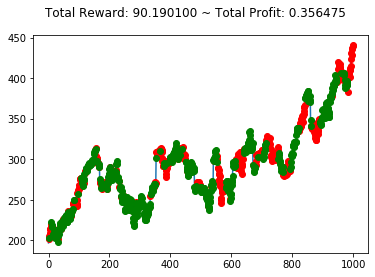

In [269]:
# train on Google stock data from timestep 1 to 1000
running_rewards_history = train(model, model_target, env_training, 1, True)


In [270]:
model.save("trained_model")

INFO:tensorflow:Assets written to: trained_model/assets


Text(0, 0.5, 'Running Reward')

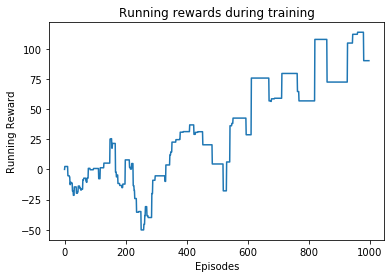

In [271]:
# plot the running rewards
plt.plot(running_rewards_history)
plt.title("Running rewards during training")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")

running reward: -19.46 at episode 50, total profit: 0.9432233391332174 epsilon 0
running reward: -26.90 at episode 100, total profit: 0.9138408696327271 epsilon 0
running reward: 67.26 at episode 150, total profit: 1.0775862276973664 epsilon 0
running reward: 85.92 at episode 200, total profit: 1.0959138642680197 epsilon 0
running reward: 85.92 at episode 250, total profit: 1.0959138642680197 epsilon 0
running reward: 101.99 at episode 300, total profit: 1.0892651961215964 epsilon 0
running reward: 92.57 at episode 350, total profit: 1.055919373467985 epsilon 0
running reward: 60.97 at episode 400, total profit: 0.9839724393934195 epsilon 0
running reward: 30.79 at episode 450, total profit: 0.9146980220716405 epsilon 0
info:  {'total_reward': 51.77816500000017, 'total_profit': 0.9199754979984507, 'position': 1}


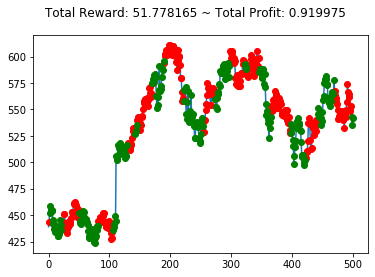

In [273]:
# test model results on the next leg of the stock data from time 1000 to 1500
#model = create_model()
#model_target = create_model()
#model = tf.keras.models.load_model("trained_model")
_ = train(model, model_target, env_1, 0, False)

*The reward of the Deep Q Learning function after training for 1000 timesteps is: 186.441452 and the total profit is 1.5480215108859194. The initial money increased by 155%.*